# Create a Dataset for Sentiment Analysis

> TL;DR In this tutorial, you'll learn how to create a dataset for Sentiment Analysis by scraping user reviews for Android apps. You'll convert the app and review information into Data Frames and save that to CSV files.

- [Read the tutorial](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1GDJIpz7BXw55jl9wTOMQDool9m8DIOyp)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Set a goal and inclusion criteria for your dataset
- Get real-world user reviews by scraping Google Play
- Use Pandas to convert and save the dataset into CSV files

## Setup

Let's install the required packages and setup the imports:

In [0]:
!pip install -qq google-play-scraper

In [0]:
!pip install -qq -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.0.3
matplotlib 3.2.1
seaborn 0.10.0
google_play_scraper 0.0.2.3


In [0]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

## The Goal of the Dataset

You want to get feedback for your app. Both negative and positive are good. But the negative one can reveal critical features that are missing or downtime of your service (when it is much more frequent).

Lucky for us, Google Play has plenty of apps, reviews, and scores. We can scrape app info and reviews using the [google-play-scraper](https://github.com/JoMingyu/google-play-scraper) package.

You can choose plenty of apps to analyze. But different app categories contain different audiences, domain-specific quirks, and more. We'll start simple.

We want apps that have been around some time, so opinion is collected organically. We want to mitigate advertising strategies as much as possible. Apps are constantly being updated, so the time of the review is an important factor.

Ideally, you would want to collect every possible review and work with that. However, in the real world data is often limited (too large, inaccessible, etc). So, we'll do the best we can.

Let's choose some apps that fit the criteria from the *Productivity* category. We'll use [AppAnnie](https://www.appannie.com/apps/google-play/top-chart/?country=US&category=29&device=&date=2020-04-05&feed=All&rank_sorting_type=rank&page_number=1&page_size=100&table_selections=) to select some of the top US apps:

In [0]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

## Scraping App Information

Let's scrape the info for each app:

In [0]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [00:02<00:00,  6.34it/s]


We got the info for all 15 apps. Let's write a helper function that prints JSON objects a bit better:

In [0]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [0]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"It\u2019s A MUST HAVE PLANNER & TO DO LIST APP\" (NYTimes, USA TODAY, WSJ & Lifehacker).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day C

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

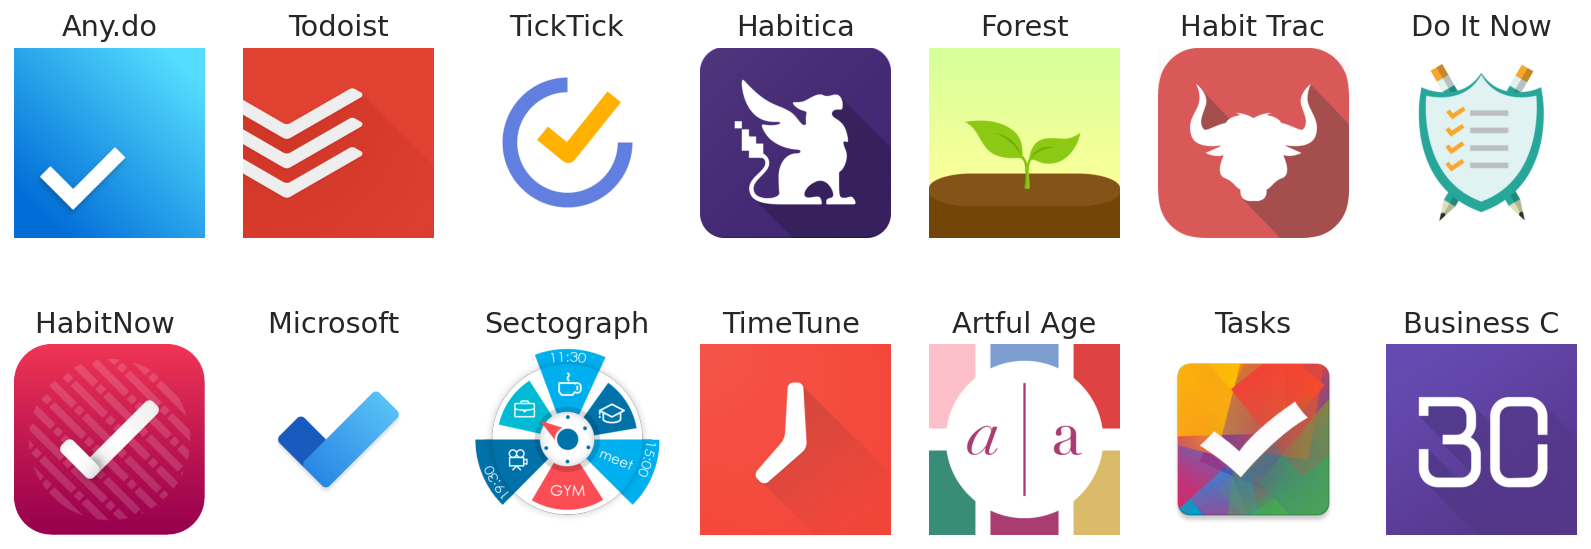

In [0]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [0]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [0]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [0]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-04-05 22:25:57",
  "content": "Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
  "repliedAt": "2020-04-07 14:09:03",
  "replyContent": "Our policy and TOS are completely transparent and can be found in the Help Center and our main page. In addition, a payment can only be made upon the user's authorization via the app and Google Play. We provide users with a full 7 days trial to test the app with an additional 48 hours for a refund, along with priority support for all issues.",
  "reviewCreatedVersion"

`repliedAt` and `replyContent` contain the developer response to the review. Of course, they can be missing.

How many app reviews did we get?



In [0]:
len(app_reviews)

15750

Let's save the reviews to a CSV file:

In [0]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

## Summary

Well done! You now have a dataset with more than 15k user reviews from 15 productivity apps. Of course, you can go crazy and get much much more.

- [Read the tutorial](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1GDJIpz7BXw55jl9wTOMQDool9m8DIOyp)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Set goals and expectations for your dataset
- Scrape Google Play app information
- Scrape user reviews for Google Play apps
- Save the dataset to CSV files

Next, we're going to use the reviews for sentiment analysis with BERT. But first, we'll have to do some text preprocessing!


## References

- [Google Play Scraper for Python](https://github.com/JoMingyu/google-play-scraper)